In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import glob

import nglview
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer

***
### Feature Selection

In [2]:
# Get topology and trajectory files. 
# Split trajectories into training set [:-1] and test set [-1]

gro = './data/peptide.gro'
trj = glob.glob('data/md_1us_*_noPBC.xtc')
train_files = trj[:-1]
test_file = trj[-1]
print(train_files, test_file)
assert set(train_files) & set(test_file) == set()

['data/md_1us_1_noPBC.xtc'] data/md_1us_0_noPBC.xtc


In [3]:
# Why not have a look at the structure

widget = nglview.show_mdtraj(mdtraj.load(gro))
p = TrajectoryPlayer(widget)
widget.add_ball_and_stick()
p.spin = True
def stop_spin():
    p.spin = False
    widget.close()
Timer(30, stop_spin).start()
widget

NGLWidget()

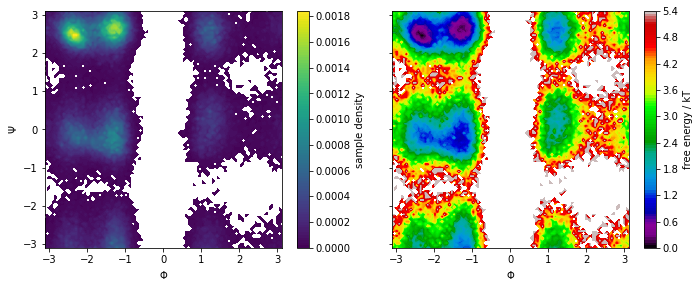

In [4]:
# Ramachandran plot and free energy plot 

feat_torsion = pyemma.coordinates.featurizer(gro)
feat_torsion.add_backbone_torsions(periodic=False)
reader_torsion = pyemma.coordinates.source(trj, features = feat_torsion)
data_plot = reader_torsion.get_output(stride = 3)

phi = np.concatenate(data_plot[0][:,::2])
psi = np.concatenate(data_plot[0][:,1::2])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_density(phi, psi, ax=axes[0])
pyemma.plots.plot_free_energy(phi, psi, ax=axes[1], legacy=False)
for ax in axes.flat:
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

In [14]:
# Select features by comparing VAMP scores at different lag times 
# backbone torsions + side chain torsions; ca distances; contacts

feat = pyemma.coordinates.featurizer(gro)

feat.active_features = []
feat.add_backbone_torsions(cossin=True, periodic=False)
#feat.add_sidechain_torsions(which='all', cossin=True, periodic=False)
data_torsions = pyemma.coordinates.load(train_files, features=feat, stride = 10)
data_torsions_test = pyemma.coordinates.load(test_file, features=feat, stride = 10)

feat.active_features = []
feat.add_distances_ca(periodic=False)
data_dists_ca = pyemma.coordinates.load(train_files, features=feat, stride = 10)
data_dists_ca_test = pyemma.coordinates.load(test_file, features=feat, stride = 10)

feat.active_features = []
pairs = feat.pairs(feat.select_Heavy())
feat.add_contacts(pairs, periodic=False)
data_contacts = pyemma.coordinates.load(train_files, features=feat, stride = 10)
data_contacts_test = pyemma.coordinates.load(test_file, features=feat, stride = 10)

In [15]:
def plot_for_lag(ax, lag, dim=3):
    vamp_torsions = pyemma.coordinates.vamp(data_torsions, lag=lag, dim=dim)
    vamp_dist_ca = pyemma.coordinates.vamp(data_dists_ca, lag=lag, dim=dim)
    vamp_contacts = pyemma.coordinates.vamp(data_contacts, lag=lag, dim=dim)

    vamps = (vamp_torsions, vamp_dist_ca, vamp_contacts)
    test_data = (data_torsions_test, data_dists_ca_test, data_contacts_test)
    labels = ('torsions', 'CA distances', 'contacts')
    for i, (v, test_data) in enumerate(zip(vamps, test_data)):
        s = v.score(test_data=test_data)
        ax.bar(i, s)
    ax.set_title('VAMP2 @ lag = {} ps'.format(lag))
    ax.set_xticks(range(len(vamps)))
    ax.set_xticklabels(labels)
    fig.tight_layout()

In [ ]:
# Compute VAMP scores at different lag times
# This is to ensure that our selected feature is robust as a function of lag time
# The dimension is set to 3. How can VAMP scores higher than 3 ...?
# It takes hours don't run 

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
plot_for_lag(axes[0], 5)
plot_for_lag(axes[1], 10)
plot_for_lag(axes[2], 20)
plot_for_lag(axes[3], 50)

***
### Dimensionality Reduction and Discretisation

In [4]:
# Decided to use backbone torsions in cos and sin (4*14 = 56 features per frame)
# Perform TICA and VAMP transformation on the feature space
# Reduce the feature space dimensions to (35*length)

feat = pyemma.coordinates.featurizer(gro)
feat.active_features = []
feat.add_backbone_torsions(cossin=True, periodic=False)
reader = pyemma.coordinates.source(trj, features = feat)

tica = pyemma.coordinates.tica(reader, lag = 10, var_cutoff = 0.95, stride = 3)
tica_output = tica.get_output(stride = 1)
tica_concatenated = tica_output[0]
vamp = pyemma.coordinates.vamp(reader, lag = 10, dim = 0.95, stride = 3)
vamp_output = vamp.get_output(stride = 1)
vamp_concatenated = vamp_output[0]
print('TICA subspace shape', tica_concatenated.shape)
print('VAMP subspace shape', vamp_concatenated.shape)

TICA subspace shape (25001, 35)
VAMP subspace shape (25001, 35)


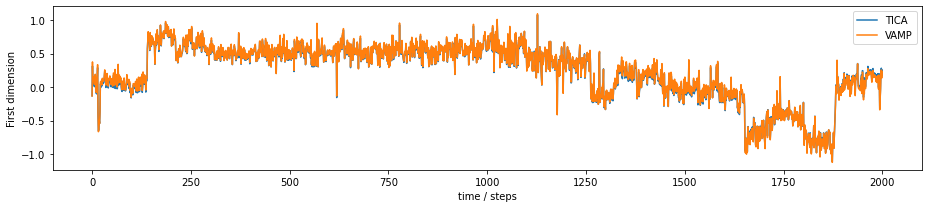

In [5]:
# TICA and VAMP performed almost the same transformation
# Plot the first IC as a time series. Does it resolve any metastability??

fig, ax = plt.subplots(figsize=(13, 3))
ax.plot(tica_concatenated[:2000,1], label = 'TICA')
ax.plot(vamp_concatenated[:2000,1] *-1, label = 'VAMP')
ax.set_xlabel('time / steps')
ax.set_ylabel('First dimension')
ax.legend()
fig.tight_layout()

In [6]:
# Clustering the TICA subspace into 300 kmeans centers
# Now each frame has been assigned to a discrete state

cluster = pyemma.coordinates.cluster_kmeans(tica, k = 300, max_iter = 100, stride = 10)
print(cluster.clustercenters.shape)
print(len(cluster.dtrajs), cluster.dtrajs[0].shape)

initialize kmeans++ centers:   0%|                                                              | 0/300 [00:00…

kmeans iterations:   0%|                                                                        | 0/100 [00:00…

(300, 35)
2 (25001,)


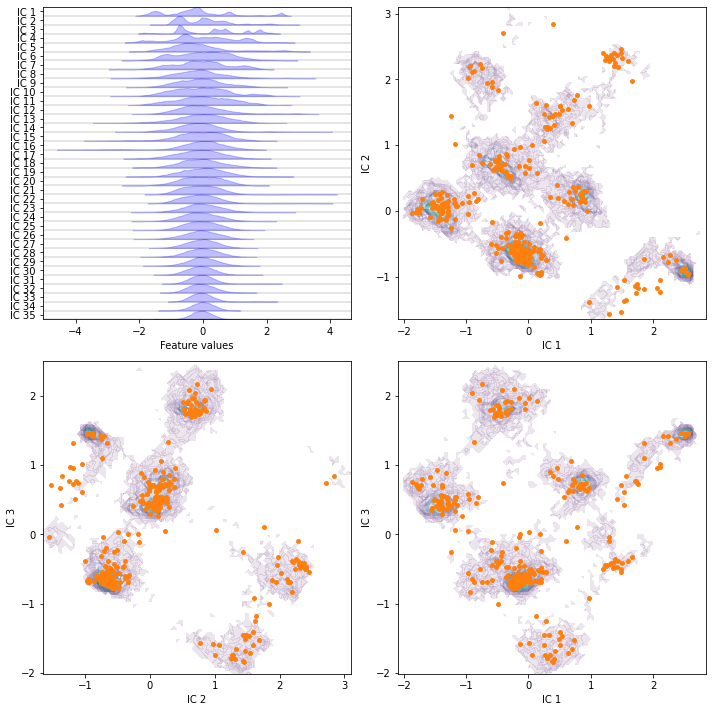

In [7]:
# Plot marginal distributions and pairwise joint distributions of the top three independent components with cluster centers

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *tica_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

*** 
### MSM estimation and validation

estimating BayesianMSM:   0%|                                                                    | 0/24 [00:00…

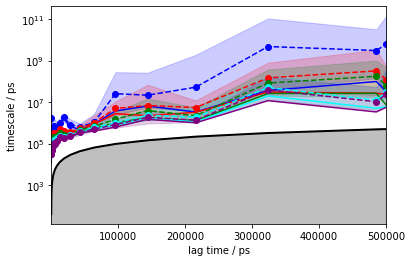

In [12]:
# Plot implied timescales aginast lag time
# Lag times at which ITS is computed automatically. Number of ITSs is set to 5.
# Each frame correspond to 40 ps

its = pyemma.msm.its(cluster.dtrajs, nits = 4, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units = 'ps', dt = 40)
fig.tight_layout()

In [ ]:
# ITS convergence test for different number of cluster centers

fig, axes = plt.subplots(4, 2, figsize=(8, 32))
for i, k in enumerate([100, 200, 250, 400]):
    cluster_test = pyemma.coordinates.cluster_kmeans(tica, k=k, max_iter=200, stride=10)
    pyemma.plots.plot_density(*tica[:,:2].T, ax=axes[i, 0], cbar=False, alpha=0.1)
    axes[i, 0].scatter(*cluster_test.clustercenters[:, :2].T, s=15, c='C1')
    axes[i, 0].set_xlabel('$\IC1$')
    axes[i, 0].set_ylabel('$\IC2$')
    axes[1, 0].set_title('k = {} centers'.format(k))
    pyemma.plots.plot_implied_timescales(pyemma.msm.its(cluster_test.dtrajs, nits=4, errors='bayes'), 
                                         ax=axes[i, 1], units='ps', dt = 40)
fig.tight_layout()

In [ ]:
# 
# Then perform a CK test to confirm whether this model satifies Markovianity
# The number of metastable states chosen to be 5

msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')
pyemma.plots.plot_cktest(msm.cktest(4), units='ps');